# Problema de negócio. 

- Empresa precia saber a previsão diária das vendas das proximas 6 semanas para reforma das lojas.


# 0.0 - IMPORTS

In [3]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import inflection
import math
import warnings
import numpy.testing as testing
import xgboost       as xgb

from matplotlib            import pyplot  as plt
from scipy                 import stats   as ss
from datetime              import datetime, timedelta
from matplotlib.gridspec   import GridSpec
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error , mean_squared_error
from sklearn.ensemble      import RandomForestRegressor


In [4]:
# Ignora todos os avisos
warnings.filterwarnings("ignore")

## 0.1 helper function

## 0.2 loading data 

In [7]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)

In [8]:
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [9]:
df_raw = pd.merge (df_sales_raw , df_store_raw, how = 'left', on='Store')

In [10]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
576366,697,5,2014-01-31,12244,1076,1,0,0,0,d,a,3780.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
349568,64,1,2014-09-01,13524,932,1,1,0,0,d,c,22560.0,NaN,NaN,1,14.0,2013.0,"Jan,Apr,Jul,Oct"
563938,534,2,2014-02-11,5108,436,1,0,0,0,d,a,1200.0,9.0,2009.0,1,45.0,2009.0,"Jan,Apr,Jul,Oct"
38407,498,6,2015-06-27,8028,915,1,0,0,0,a,a,990.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
185770,681,7,2015-02-15,0,0,0,0,0,0,a,c,620.0,NaN,NaN,1,1.0,2014.0,"Mar,Jun,Sept,Dec"


# 1.0 DATA DESCRIPTION

In [12]:
# know all data and know all dimentions we are working whith to check if we have all equipment necessary. 

## 1.1 rename columns

In [14]:
df1 = df_raw.copy() #copy for safety and run this work by parts easily.

In [15]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [16]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list( map( snakecase, cols_old ))

df1.columns = cols_new

In [17]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 data description

In [19]:
df1.shape

print(f'numero de linhas: {df1.shape[0]}')
print(f'numero de colunas: {df1.shape[1]}')

numero de linhas: 1017209
numero de colunas: 18


In [20]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [21]:
df1['date'] = pd.to_datetime(df1['date'])

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.3 Adjusting date columns

In [24]:
df1['date'] = pd.to_datetime(df1['date']) #adjusting column date

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 check NAN

In [27]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 fill NaN

In [29]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)#é usado math para verificar os nan porque a coluna é float

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map']      = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1 )

In [30]:
df1.isna().sum() #nan tratados

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.6 change columns's types

In [33]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [34]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

## 1.7 descriptive statistical

In [36]:
#spare caregories and numbers columns.
num_attributes = df1.select_dtypes(include = ['int64','int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int32','int64', 'float64','datetime64[ns]' ])

In [37]:
num_attributes.dtypes

store                             int64
day_of_week                       int64
sales                             int64
customers                         int64
open                              int64
promo                             int64
school_holiday                    int64
competition_distance            float64
competition_open_since_month      int32
competition_open_since_year       int32
promo2                            int64
promo2_since_week                 int32
promo2_since_year                 int32
is_promo                          int64
dtype: object

### 1.7.1 numerical atributes

In [39]:
# criating a dataframe with mean, median, std, min, max , range, skew and kutosis.

In [40]:
#central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(num_attributes.apply ( np.std )).T
d2 = pd.DataFrame(num_attributes.apply ( min )).T
d3 = pd.DataFrame(num_attributes.apply ( max )).T              
d4 = pd.DataFrame(num_attributes.apply ( lambda x: x.min()- x.max() )).T
d5 = pd.DataFrame(num_attributes.apply ( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply ( lambda x: x.kurtosis())).T
                   

In [41]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6], axis=0).T

In [42]:
m.columns= ['min', 'max', 'range','mean', 'median', 'std', 'skew', 'kurtosis']

In [43]:
m

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,-1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,-6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,-41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,-7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,-1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,-1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,-1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,-199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,-11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,-115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 [Text(-10000.0, 0, '−10000'),
  Text(0.0, 0, '0'),
  Text(10000.0, 0, '10000'),
  Text(20000.0, 0, '20000'),
  Text(30000.0, 0, '30000'),
  Text(40000.0, 0, '40000'),
  Text(50000.0, 0, '50000')])

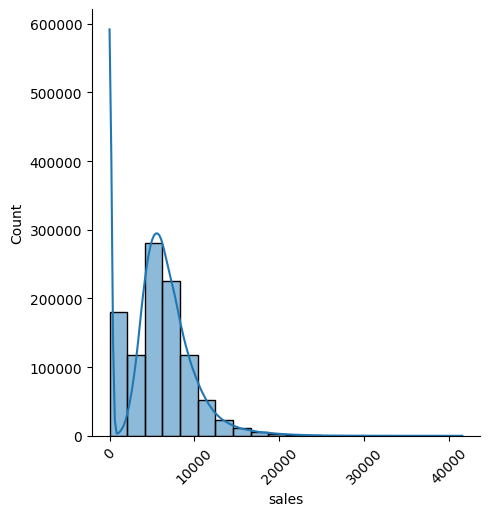

In [44]:
sns.displot(data=df1,bins =20, x='sales', kde=True)
plt.xticks(rotation=45)

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 [Text(-10000.0, 0, '−10000'),
  Text(0.0, 0, '0'),
  Text(10000.0, 0, '10000'),
  Text(20000.0, 0, '20000'),
  Text(30000.0, 0, '30000'),
  Text(40000.0, 0, '40000'),
  Text(50000.0, 0, '50000')])

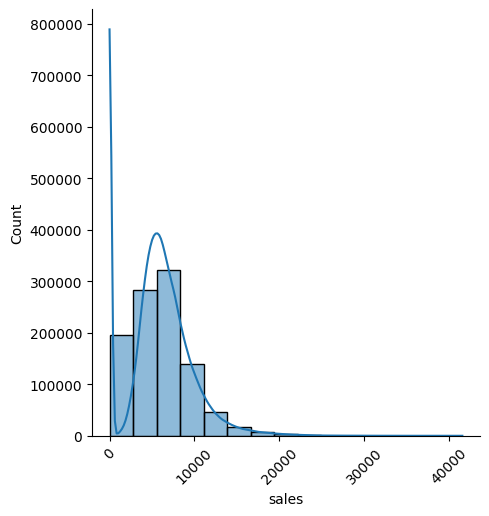

In [45]:
sns.displot(df1['sales'], bins=15, kde=True)
plt.xticks(rotation=45)

(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000., 200000., 225000.]),
 [Text(-25000.0, 0, '−25000'),
  Text(0.0, 0, '0'),
  Text(25000.0, 0, '25000'),
  Text(50000.0, 0, '50000'),
  Text(75000.0, 0, '75000'),
  Text(100000.0, 0, '100000'),
  Text(125000.0, 0, '125000'),
  Text(150000.0, 0, '150000'),
  Text(175000.0, 0, '175000'),
  Text(200000.0, 0, '200000'),
  Text(225000.0, 0, '225000')])

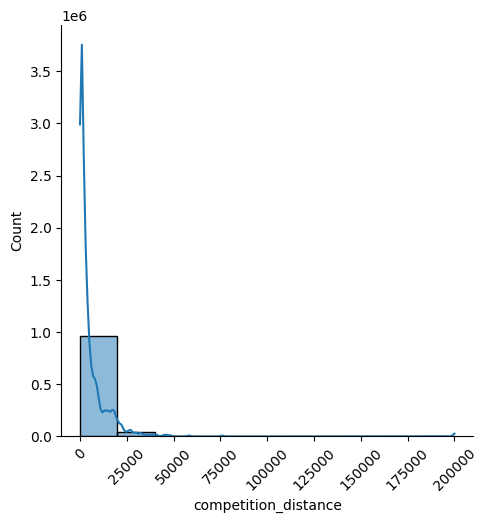

In [46]:
sns.displot(df1['competition_distance'],bins=10,  kde=True) 
plt.xticks(rotation=45)

### 1.7.2 categorical attibrutes

In [48]:
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [49]:
sales_hollyday = df1.loc[df1['state_holiday'] != '0', :]

In [50]:
data_aux = sales_hollyday.loc[sales_hollyday['sales']>0 , :]

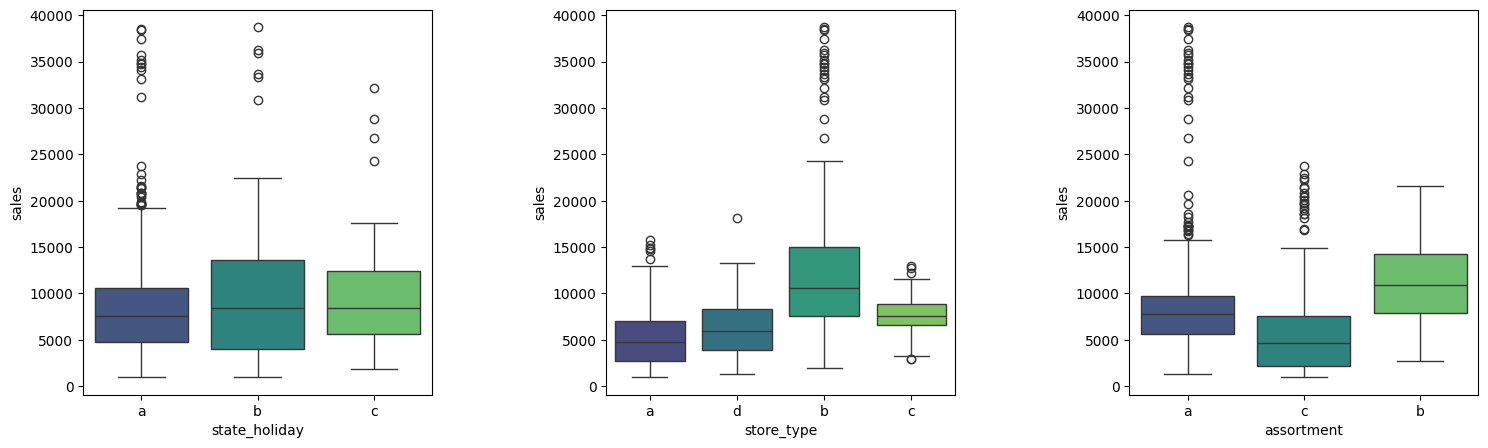

In [51]:
plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales', data=data_aux, palette='viridis')

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=data_aux, palette='viridis')

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y= 'sales', data=data_aux, palette='viridis')

plt.subplots_adjust(wspace=0.5)

plt.show()


# 2.0 FEATURE ENGINEERING

## 2.1 Creating Hypotheses

#### 2.1.1 - Criação das hipoteses

Hipoteses Loja
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

#### 2.1.3 - Lista final de hipoteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [59]:
df2 = df1.copy() #fazendo copia do arquivo para começar a partir daqui depois das monificações e otimizar o código.

In [60]:
df2.shape

(1017209, 20)

In [61]:
#criando variaveis derivadas

In [62]:
df2['year'] = df2['date'].dt.year # year
df2['month'] = df2['date'].dt.month # month
df2['day'] = df2['date'].dt.day # day
df2['week_of_year'] = df2['date'].dt.isocalendar().week #week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') #year week

In [63]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [64]:
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

In [65]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

In [66]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

In [67]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c'
else 'regular_day' )

# 3.0 CHOOSING FEATURES

In [69]:
df3 = df2.copy()

## 3.1 Choosing lines and columns to work

In [71]:
columns_keep = ['store', 
                'day_of_week', 
                'date', 
                'sales', 
                'promo',
                'state_holiday', 
                'school_holiday', 
                'store_type', 
                'assortment',
                'competition_distance', 
                'competition_open_since_month',
                'competition_open_since_year', 
                'promo2', 'promo2_since_week',
                'promo2_since_year', 
                'is_promo', 'year',
                'month', 
                'day', 
                'week_of_year', 
                'year_week', 
                'competition_since',
                'competition_time_month', 
                'promo_since', 
                'promo_time_week']

In [72]:
df3 = df3.loc[ (df3['open'] != 0) & (df3['sales']>0), columns_keep ] 

# 4.0 EXPLORATORY DATA ANALYSIS (EDA)

## 4.1 Análise univariada

In [75]:
df4 = df3.copy()

### 4.1.1. Response Variable

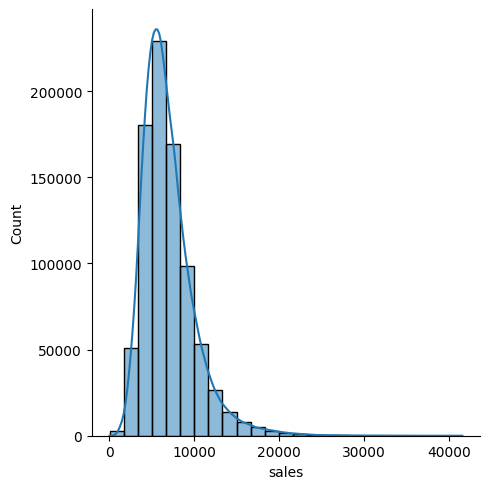

In [77]:
sns.displot(df4['sales'], bins=25, kde='false')

### 4.1.2. Numerical Variable

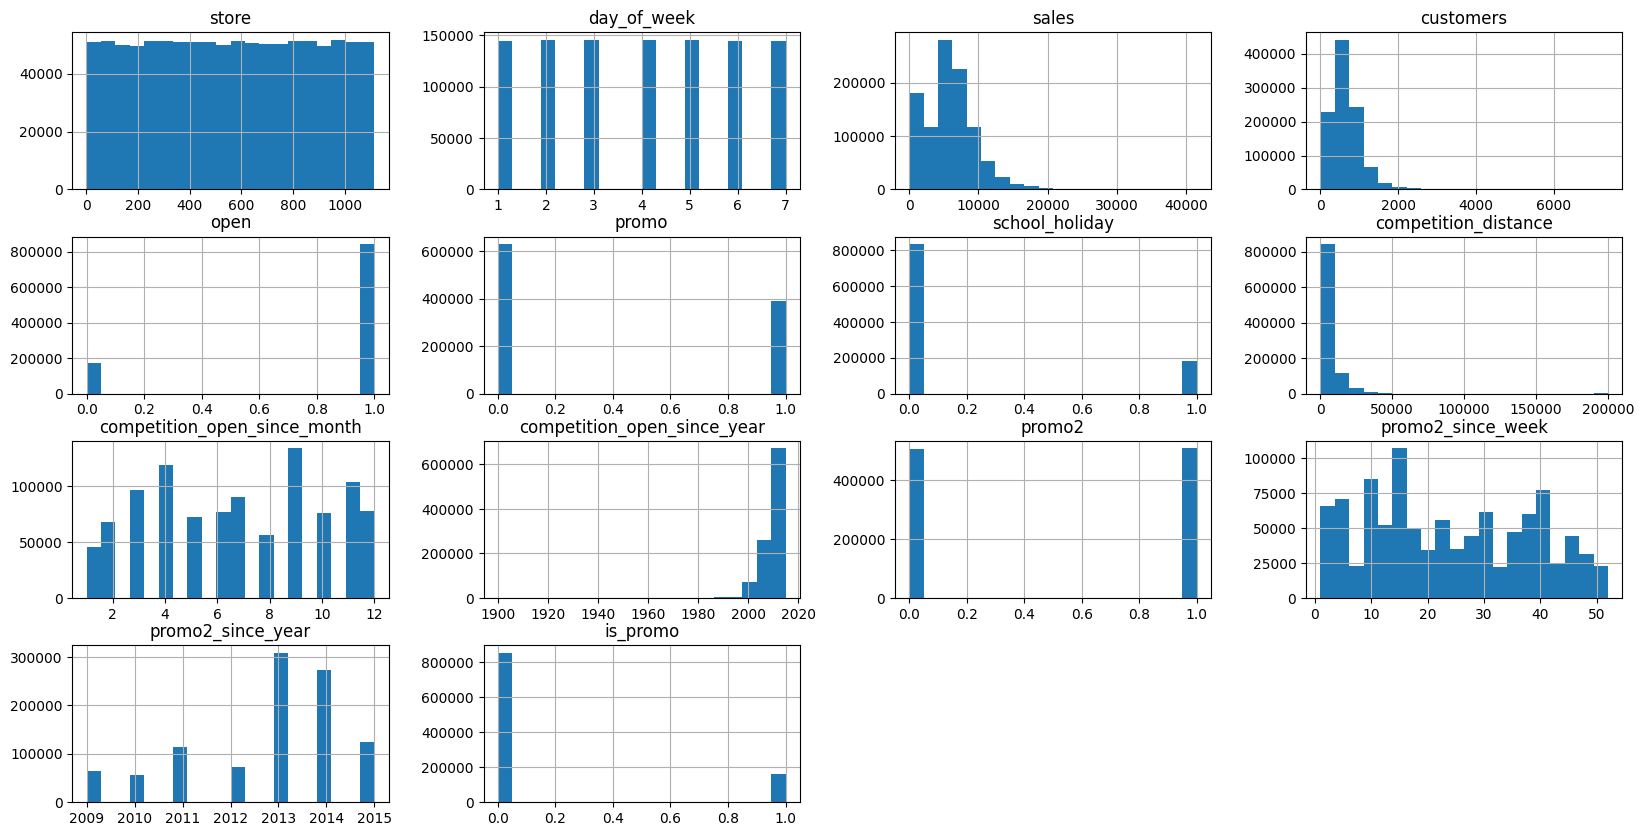

In [79]:
num_attributes.hist(bins = 20, figsize=(20, 10)); # num_attributes é um dataframe criada apenas com números na etapa de estatistica descritiva.

### 4.1.3 Categorical Variable

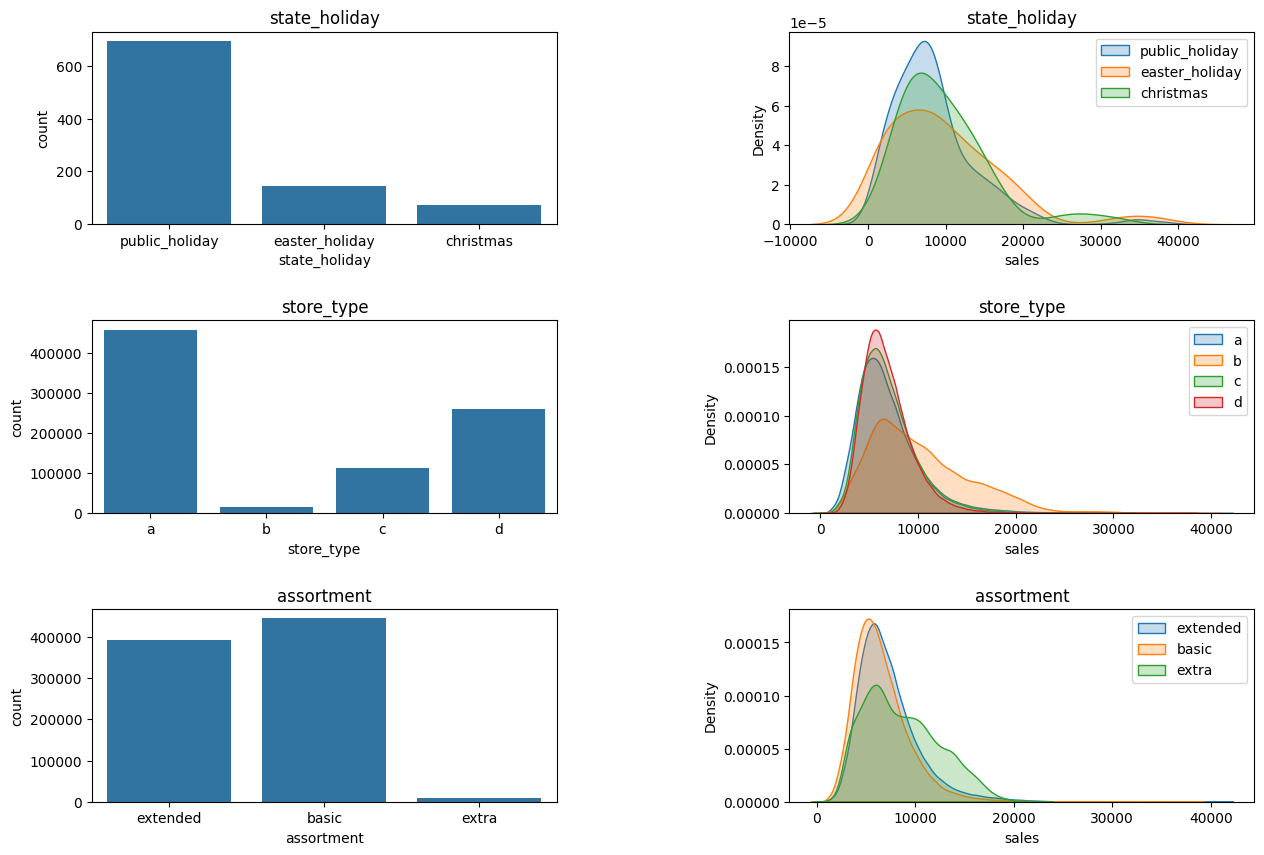

In [81]:
# state_holiday

#tamanho dos graficos
plt.figure(figsize=(15, 10))

#ordem de linhas, colunas e o index do grafico abaixo
plt.subplot( 3, 2, 1) 
#selecao de dados, separando os dias regulares de feriados e colunas.
a = df4.loc[(df4['state_holiday'] != 'regular_day'), ['state_holiday', 'sales']] 
#montando gráfico com state holiday 
sns.countplot( x = a['state_holiday'], order = ['public_holiday', 'easter_holiday', 'christmas']) 
plt.title('state_holiday')

#ordem de linhas, colunas e o index do grafico abaixo
plt.subplot( 3, 2, 2 )
#grafico de densidade sobreposto feriados.
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()
plt.title('state_holiday')

#ordem de linhas, colunas e o index do grafico abaixo
plt.subplot( 3, 2, 3)
#separando dados para trabalhar
b = df4.loc[:, ['store_type','sales'] ]
#grafico de barras
sns.countplot(x = b['store_type'] , order = ['a', 'b','c','d']  )  
plt.title('store_type')

#ordem de linhas, colunas e o index do grafico abaixo
plt.subplot( 3, 2, 4)
#grafico de densidade sobreposto feriados.
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend() #legenda do grafico sobreposto
plt.title('store_type')

#ordem de linhas, colunas e o index do grafico abaixo
plt.subplot( 3, 2, 5)
#separando dados para trabalhar
c = df4.loc[:, 'assortment'] 
#montando gráfico de barras
sns.countplot(x = c , order = ['extended', 'basic', 'extra'] )  
plt.title('assortment')

#ordem de linhas, colunas e o index do grafico abaixo
plt.subplot( 3, 2, 6)
#separando dados para trabalhar
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()
plt.title('assortment')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

## 4.2 Análise bivariada

In [83]:
## H1. Lojas com maior sortimentos deveriam vender mais.FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

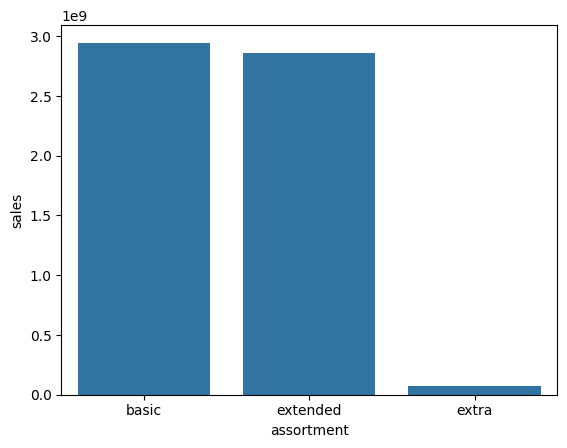

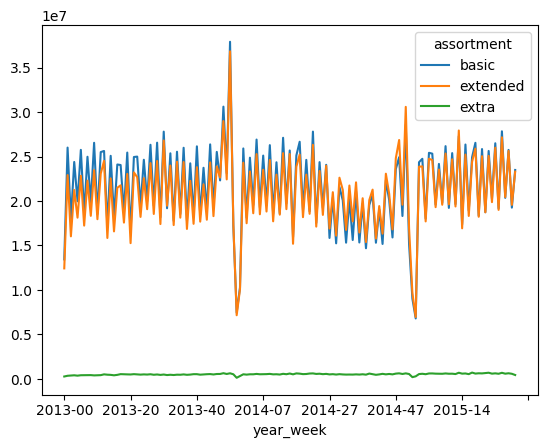

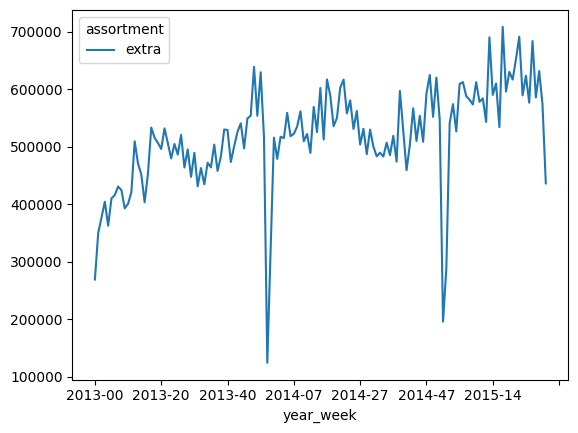

In [84]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


In [85]:
# H2. Lojas com competidores mais próximos deveriam vender menos.FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

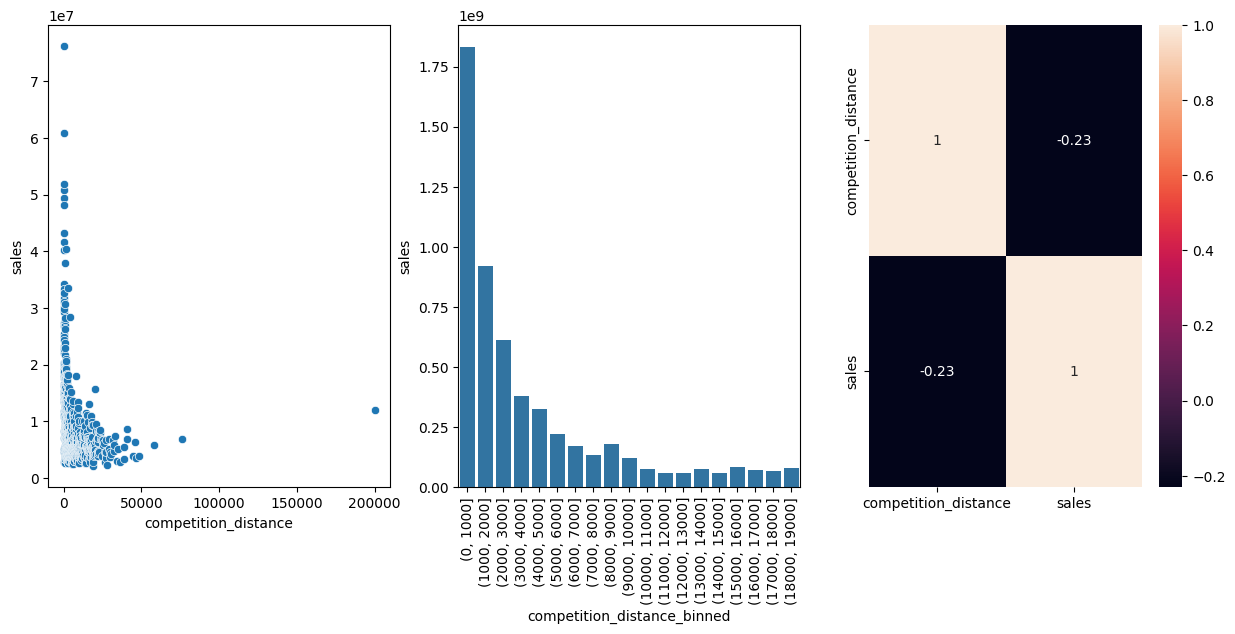

In [86]:

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.figure(figsize=(15,6))

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True, cbar = True );

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );


In [87]:
#H3. Lojas com competidores à mais tempo deveriam vendem mais.
#FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

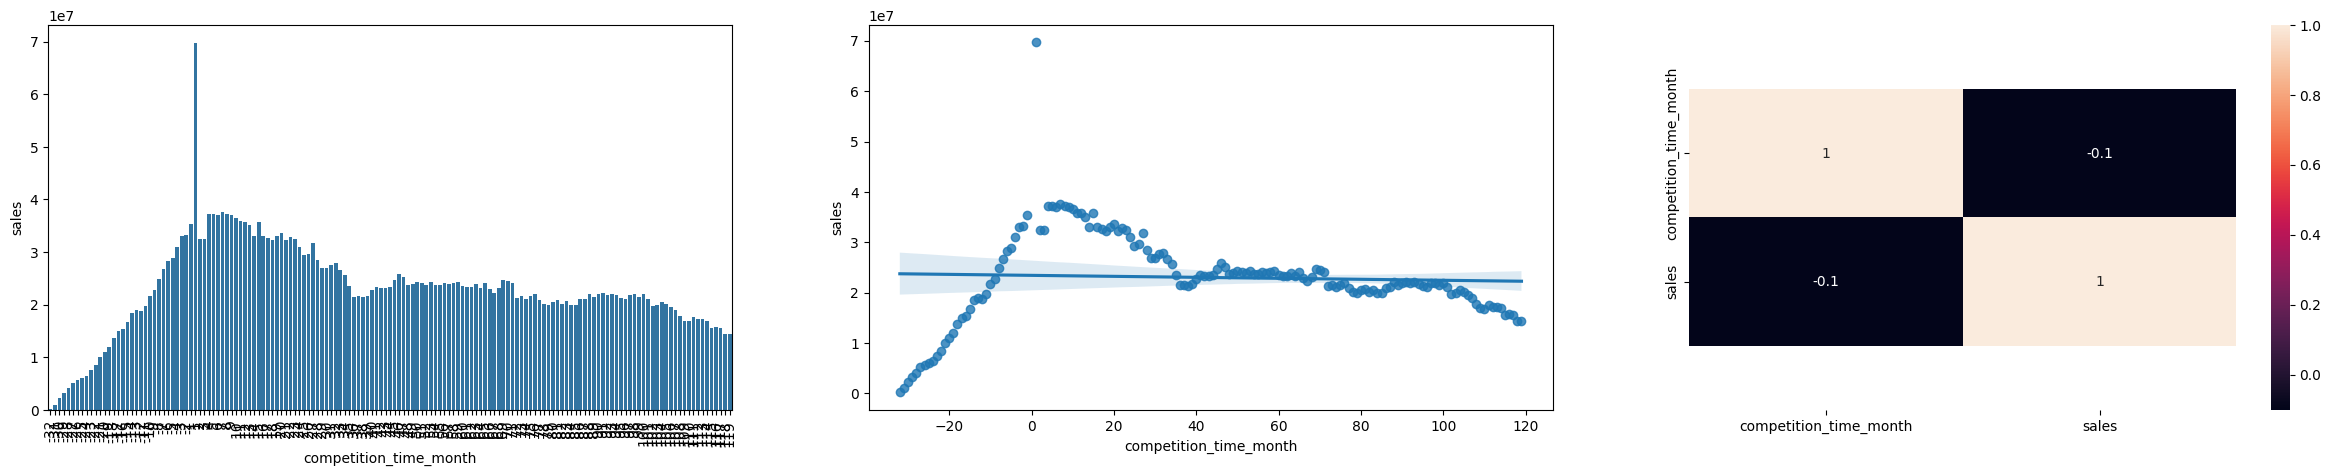

In [88]:
#filtragem dos dados 
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]

plt.figure(figsize=(30,5))

plt.subplot( 1, 3, 1 )
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

In [89]:
# H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
# FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

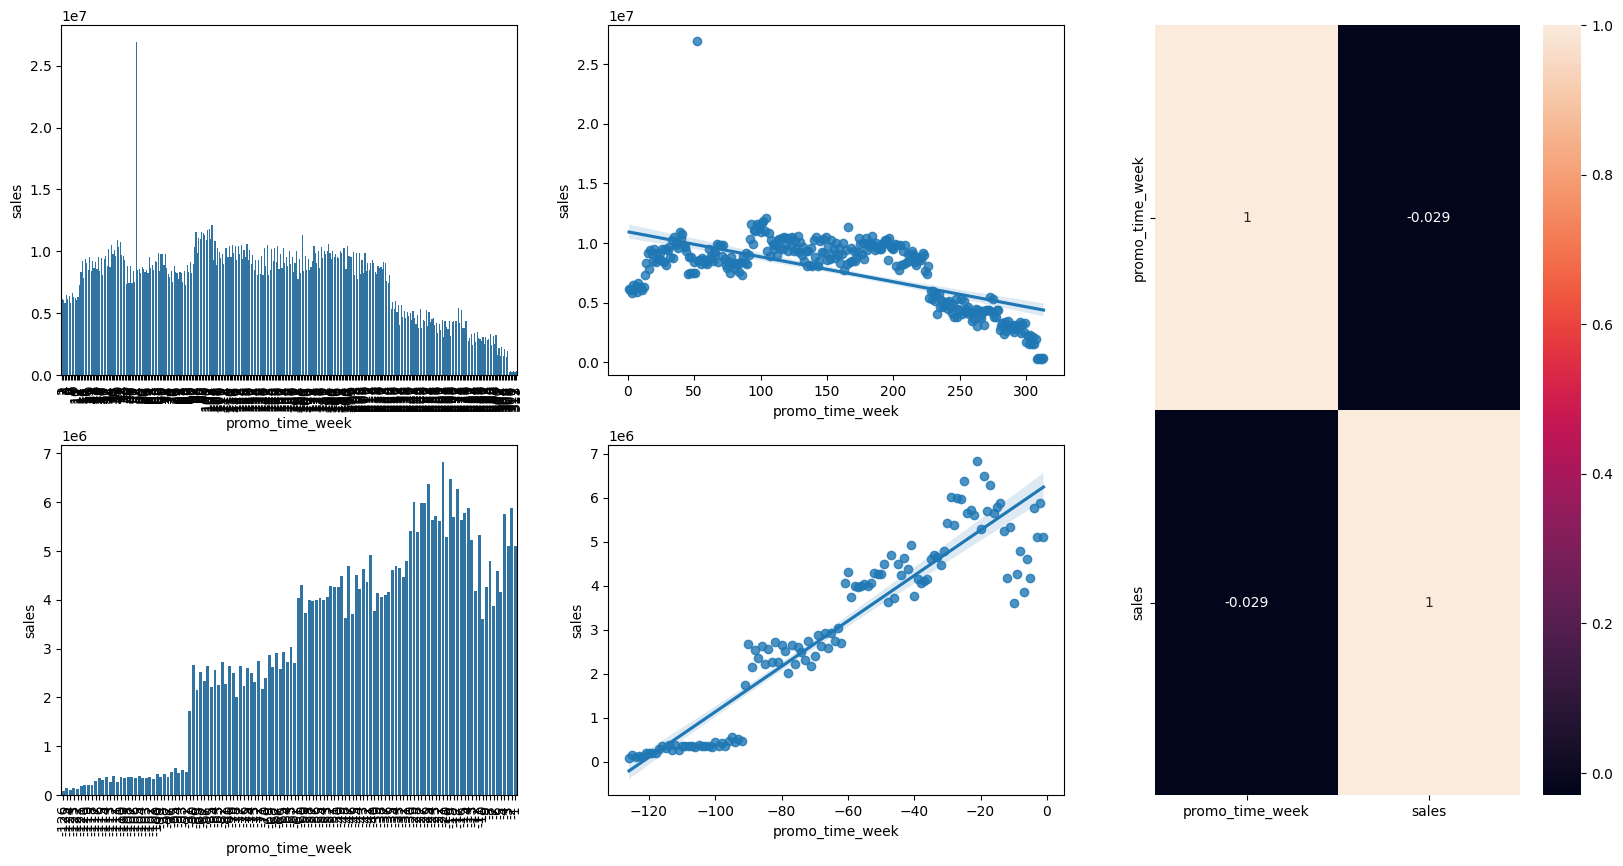

In [90]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

plt.figure(figsize=(20,10))


grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido

sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [91]:
# H7. Lojas com mais promoções consecutivas deveriam vender mais.
#FALSA Lojas com mais promocoes consecutivas vendem menos

In [92]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Text(0, 0.5, 'Vendas')

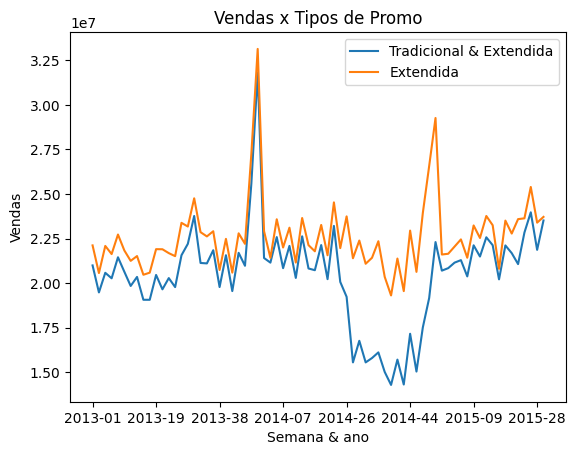

In [93]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot( x='year_week', y='sales' )

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( x='year_week', y='sales', ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);
ax.set_title("Vendas x Tipos de Promo")
ax.set_xlabel("Semana & ano")
ax.set_ylabel("Vendas")

In [94]:
#H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#FALSA Lojas abertas durante o feriado do Natal vendem menos.

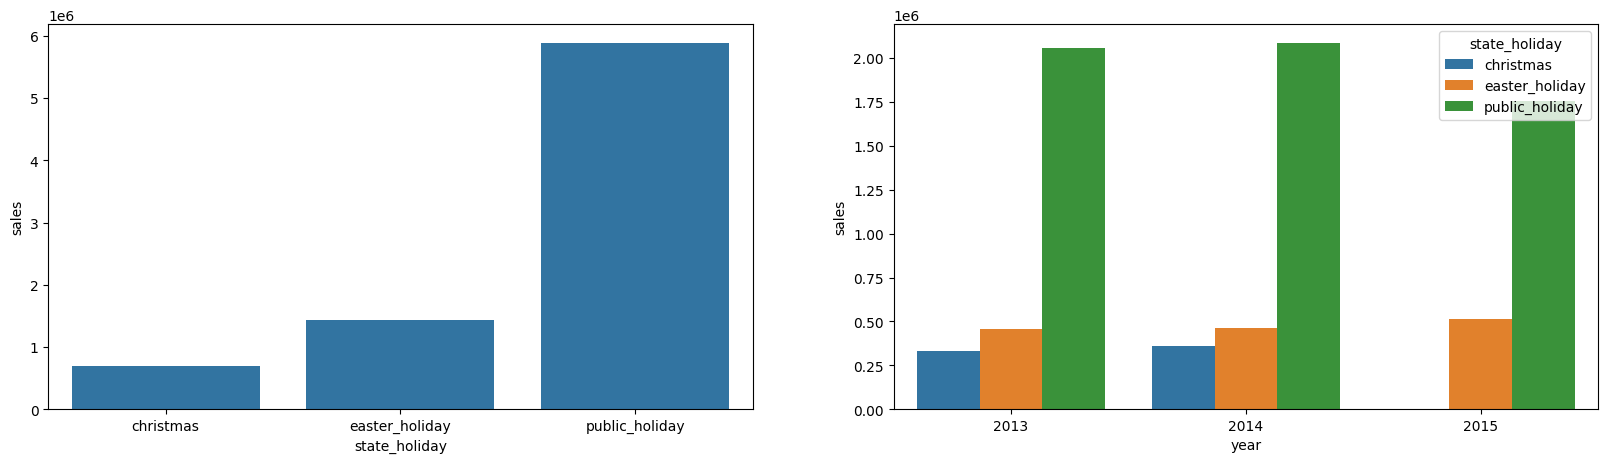

In [95]:
plt.figure(figsize=(20,5))

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

In [96]:
#H9. Lojas deveriam vender mais ao longo dos anos.
#FALSA Lojas vendem menos ao longo dos anos

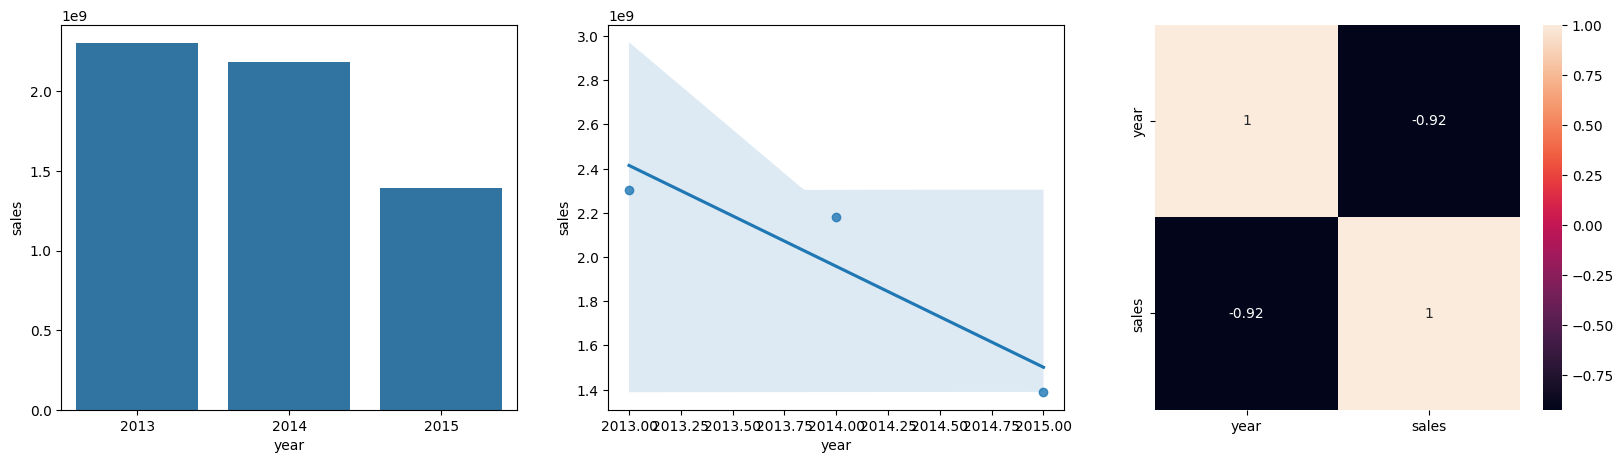

In [97]:
plt.figure(figsize=(20,5))

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


In [98]:
#H10. Lojas deveriam vender mais no segundo semestre do ano.
#FALSA Lojas vendem menos no segundo semestre do ano

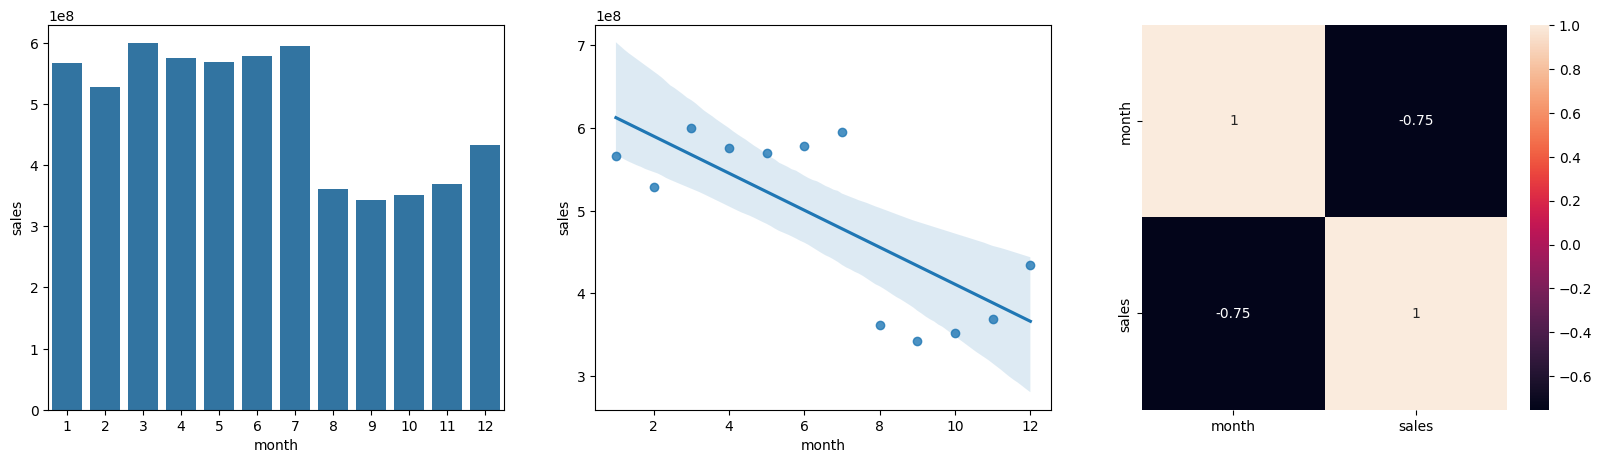

In [99]:
plt.figure(figsize=(20,5))

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [100]:
#H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
# VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.

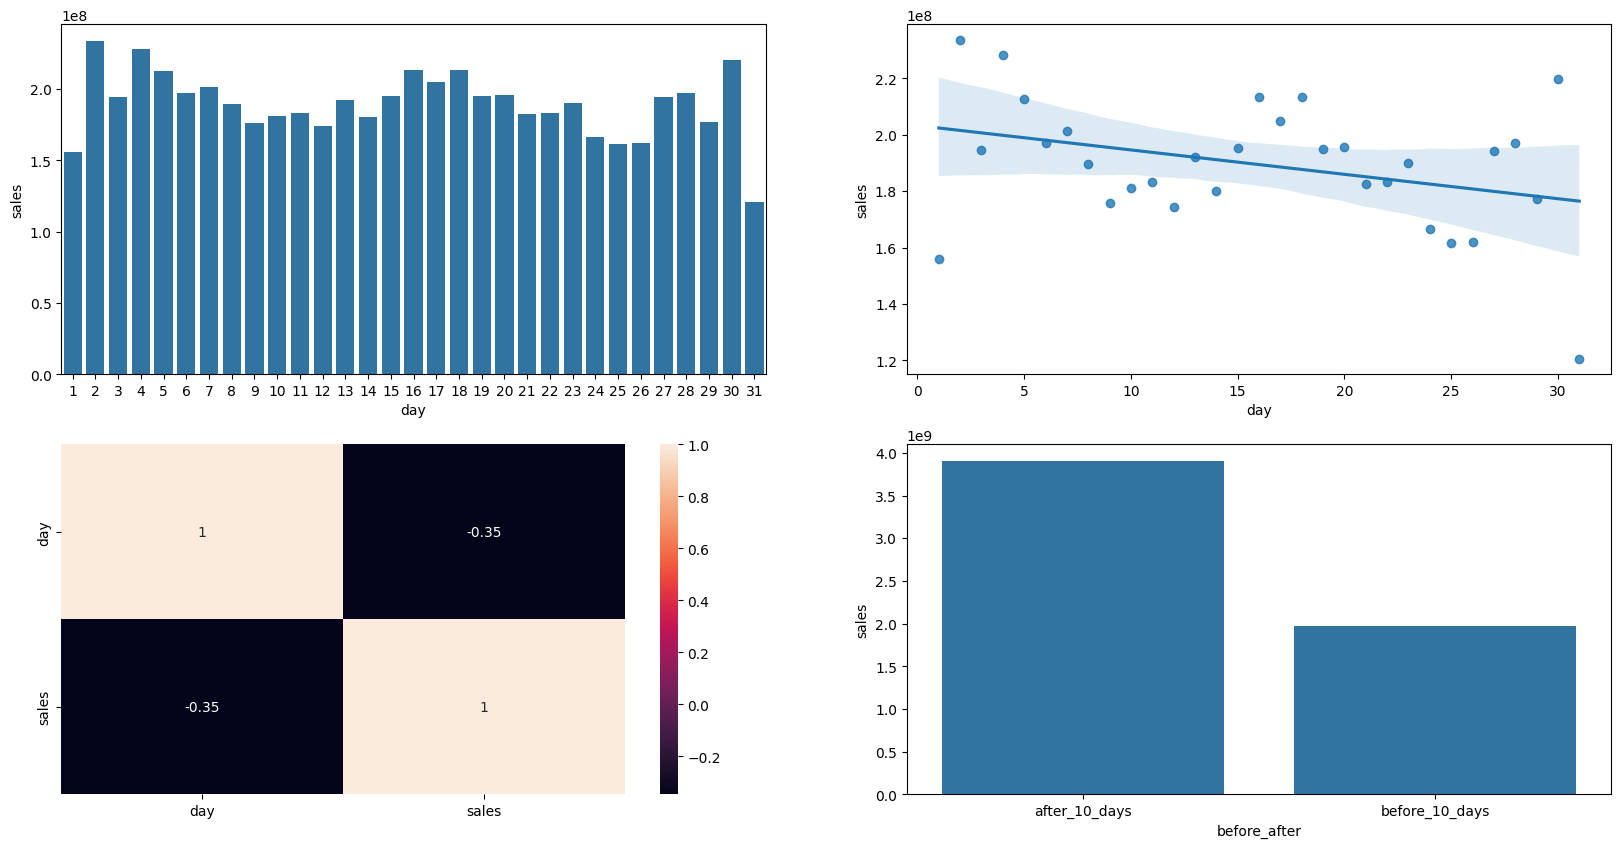

In [101]:
plt.figure(figsize=(20,10))

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );




In [102]:
#H12. Lojas deveriam vender menos aos finais de semana.
# VERDADEIRA Lojas vendem menos nos final de semana

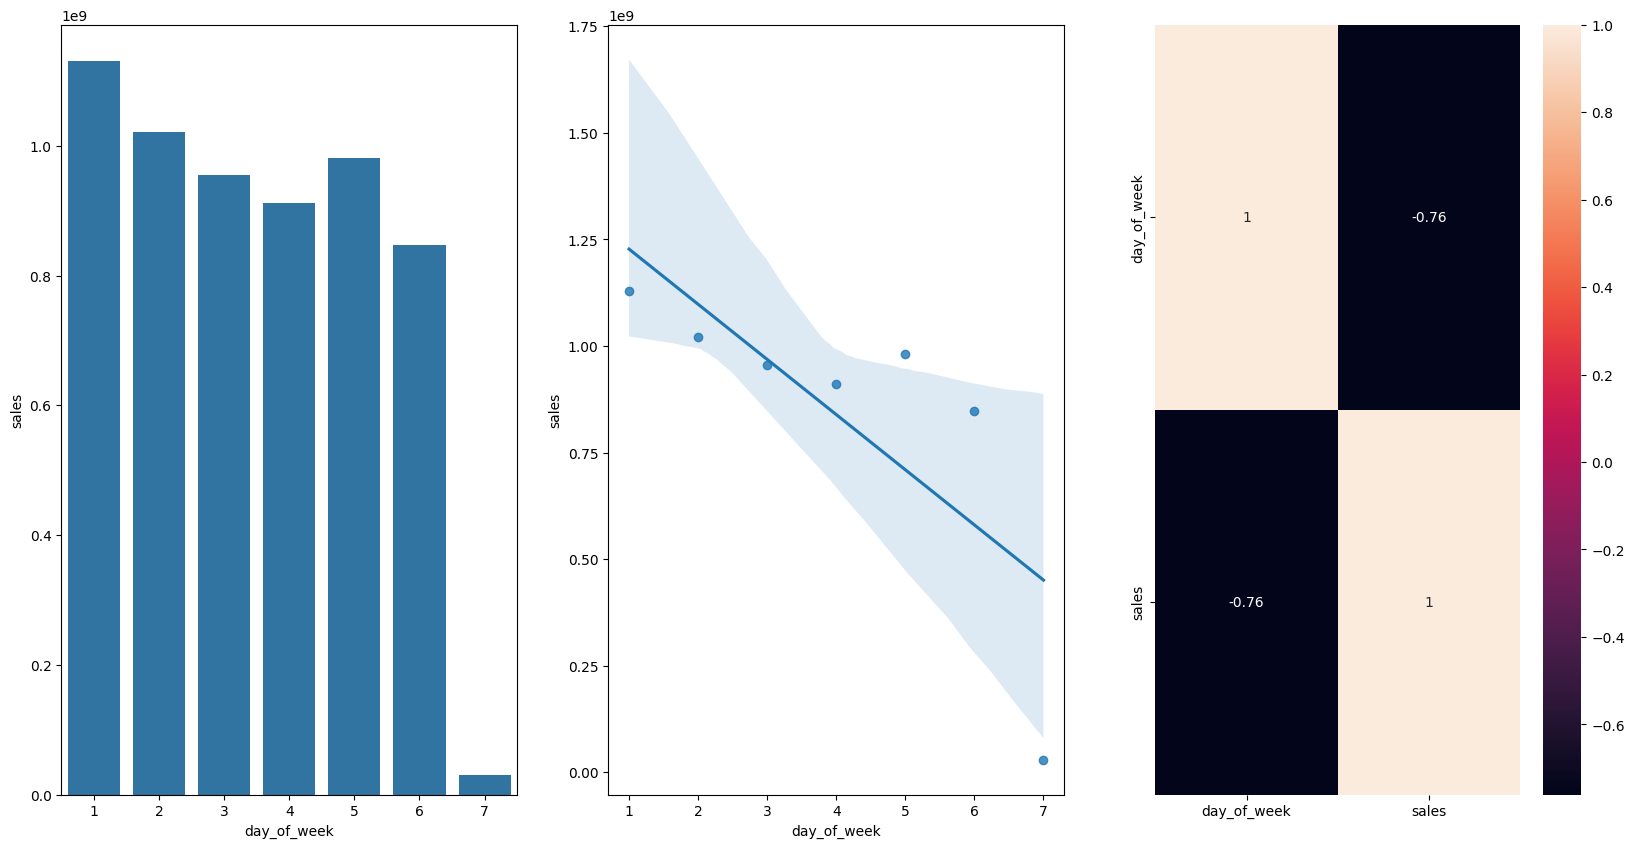

In [103]:
plt.figure(figsize=(20,10))

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



In [104]:
#H13. Lojas deveriam vender menos durante os feriados escolares.
# VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

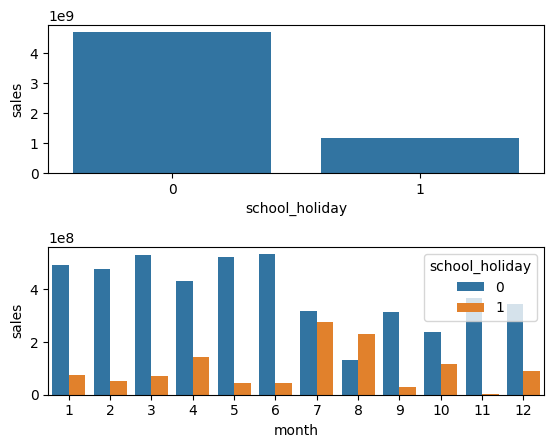

In [105]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

plt.subplots_adjust( hspace=0.5)

In [106]:
from tabulate import tabulate
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
['H1: Lojas com maior sortimentos deveriam vender mais', 'Falsa', 'Baixa'],
['H2: Lojas com competidores mais próximos deveriam vender menos', 'Falsa', 'Media'],
['H3: Lojas com competidores à mais tempo deveriam vendem mais', 'Falsa', 'Media'],
['H4: Lojas com promoções ativas por mais tempo deveriam vender mais', 'Falsa', 'Baixa'],
['H7: Lojas com mais promoções consecutivas deveriam vender mais', 'Falsa', 'Baixa'],
['H8: Lojas abertas durante o feriado de Natal deveriam vender mais', 'Falsa', 'Media'],
['H9: Lojas deveriam vender mais ao longo dos anos', 'Falsa', 'Alta'],
['H10: Lojas deveriam vender mais no segundo semestre do ano', 'Falsa', 'Alta'],
['H11: Lojas deveriam vender mais depois do dia 10 de cada mês', 'Verdadeira', 'Alta'],
['H12: Lojas deveriam vender menos aos finais de semana', 'Verdadeira', 'Alta'],
['H13: Lojas deveriam vender menos durante os feriados escolares', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipóteses                                                           Conclusão    Relevância
------------------------------------------------------------------  -----------  ------------
H1: Lojas com maior sortimentos deveriam vender mais                Falsa        Baixa
H2: Lojas com competidores mais próximos deveriam vender menos      Falsa        Media
H3: Lojas com competidores à mais tempo deveriam vendem mais        Falsa        Media
H4: Lojas com promoções ativas por mais tempo deveriam vender mais  Falsa        Baixa
H7: Lojas com mais promoções consecutivas deveriam vender mais      Falsa        Baixa
H8: Lojas abertas durante o feriado de Natal deveriam vender mais   Falsa        Media
H9: Lojas deveriam vender mais ao longo dos anos                    Falsa        Alta
H10: Lojas deveriam vender mais no segundo semestre do ano          Falsa        Alta
H11: Lojas deveriam vender mais depois do dia 10 de cada mês        Verdadeira   Alta
H12: Lojas deveriam vender menos a

## 4.3 Análise Multivariado

### 4.3.1. Numerical Attributes

In [109]:
correlation = num_attributes.corr(method='pearson').fillna(0)

<Axes: >

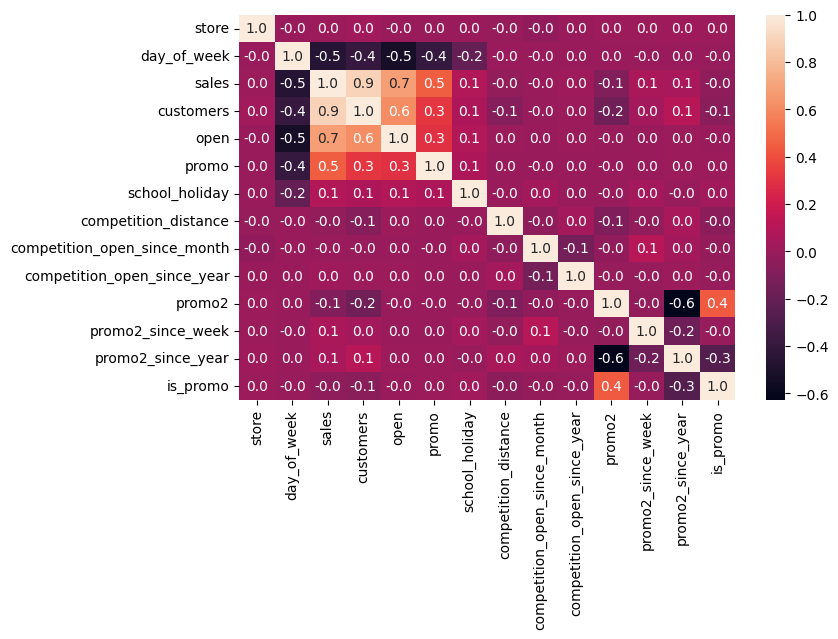

In [110]:
plt.figure(figsize=(8, 5))
sns.heatmap( correlation  , annot=True, fmt='.1f',  annot_kws={"size": 10} )

### 4.3.2. Categorical Attributes

In [112]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


In [113]:
# only categorical data
a = df4.select_dtypes( include='object' )


In [114]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'],a['state_holiday'] )
a5 = cramer_v( a['store_type'],a['store_type'] )
a6 = cramer_v( a['store_type'],a['assortment'] )
a7 = cramer_v( a['assortment'],a['state_holiday'] )
a8 = cramer_v( a['assortment'],a['store_type'] )
a9 = cramer_v( a['assortment'],a['assortment'] )

<Axes: >

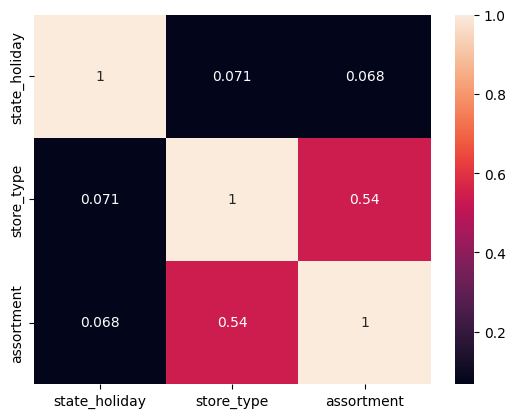

In [115]:
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )


# 05 - DATA PREPARATION

In [117]:
df5 = df4.copy()

## 5.1. Normalizacao

In [119]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

In [120]:
df5.select_dtypes( include=['int32', 'int64', 'float64'])

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.0,9,2006,0,1,2013,0,2013,1,1,77,0
1016827,733,2,10765,0,1,860.0,10,1999,0,1,2013,0,2013,1,1,161,0
1016863,769,2,5035,0,1,840.0,1,2013,1,48,2012,1,2013,1,1,0,6
1017042,948,2,4491,0,1,1430.0,1,2013,0,1,2013,0,2013,1,1,0,0


In [121]:
rs = RobustScaler()
mn = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

df5['promo_time_week'] = mn.fit_transform(df5[['promo_time_week']].values)

df5['year'] = mn.fit_transform(df5[['year']].values)

## 5.2. Encoding

In [123]:
df5.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [124]:
#tratando variaveis categoricas
df5 = pd.get_dummies(df5, prefix=['state_holiday'] , columns=['state_holiday'])

In [125]:
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])

assortment_dict = {'basic': 1, 'extra':  2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

## 5.3 response transformation 


In [127]:
df5['sales'] = np.log1p(df5['sales'])

## 5.4 Nature transformation

In [129]:
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

df5['year_sin'] = df5['year'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['year_cos'] = df5['year'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

# 6 - FEATURE SELECTION

In [131]:
df6 = df5.copy()

In [132]:
#deletar colunas que originaram outras colunas
drop_columns = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since','year_week']
df6 = df6.drop(drop_columns, axis=1)

## 6.1 Split train and test

In [134]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

In [135]:
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'  .format( X_test ['date'].min() ) )
print( 'Test Max Date: {}'    .format( X_test ['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta feature selection

In [137]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [139]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [141]:
cols_selected_boruta = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos'
]

In [142]:
# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning

In [144]:
# selecting coluns sugested by Boruta method. 
x_train = X_train[ cols_selected_boruta ] 
x_test = X_test[cols_selected_boruta ]

## 7.1 Avarage Model

In [146]:
aux1.columns
aux1 = x_test.copy() # fazendo uma cópia do arquivo teste.
aux1['sales'] = y_test.copy() 

In [147]:
# Agrupando colunas "store" e "sales", tomando como base a coluna "store" e aplicando a média. 
aux2 = aux1.loc[:, ['store', 'sales']].groupby(['store']).mean().reset_index()

aux2 = aux2.rename(columns={'sales': 'predictions'})

aux1 = pd.merge (aux1, aux2, how ='left', on ='store') #unindo colunas aux1 e aux2

In [149]:
# elaborando função para os cálculos de erro para comparação dos resultados.

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = mean_squared_error(y,yhat, squared=False)
    
    return pd.DataFrame ( { 'Model Name': model_name, 
                            'MAE': mae, 
                            'MAPE': mape,
                            'RMSE': rmse},
                             
                             index=[0] )

#elaborando função para calculo da media, que usaremos como base de comparação.

def mean_absolute_percentage_error(y,yhat):
        return np. mean(np.abs((y - yhat) / y))

In [150]:
# elaborando os resultados de modelo simples de média para usar como base de comparação. 
yhat_baseline = aux1['predictions'] # valores a serem previstos.

baseline_result = ml_error('Avarage Model',np.expm1( y_test) , np.expm1(yhat_baseline)) #comparando previsão com realidade.

## 7.2 linear Regression Model

In [152]:
from sklearn.linear_model import LinearRegression, Lasso #importando a biblioteca necessária

lr = LinearRegression().fit( x_train, y_train) # escolhendo e treinando o modelo com a base de treino.

yhat_lr = lr.predict (x_test) # testando o modelo com base teste desconhecida para verificar precisão de previsão.

lr_result = ml_error('Linear Regression', np.expm1(y_test),np.expm1( yhat_lr)) #comparando previsão com realidade.

## 7.3 linear Regression Regularized Model

In [154]:
lrr = Lasso( alpha = 0.01 ).fit (x_train, y_train) # escolhendo e treinando o modelo com a base de treino.

yhat_lrr = lrr.predict(x_test) # testando o modelo com base teste desconhecida para verificar precisão de previsão.

lrr_result = ml_error( 'Linear Regression Lasso', np.expm1(y_test),np.expm1( yhat_lrr)) #comparando previsão com realidade.

## 7.4 Random Forest Regressor

In [163]:
rf = RandomForestRegressor ( n_estimators = 50 , n_jobs=-1, random_state = 42 ).fit (x_train, y_train)

yhat_rfregressor = rf.predict (x_test)

rf_result = ml_error ('Random Forest Regressor',  np.expm1(y_test),np.expm1( yhat_rfregressor )).round(2)

## 7.5 XGBoost Regressor 

In [167]:
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                              n_estimators = 100, 
                              eta = 0.01, 
                              max_depth = 10, 
                              subsample = 0.7, 
                              colsample_byteee = 0.9 ).fit (x_train, y_train)


yhat_xgbregressor = model_xgb.predict (x_test)

xgb_result = ml_error ('XG Boost Regressor',  np.expm1(y_test),np.expm1( yhat_xgbregressor )).round(2)
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XG Boost Regressor,1665.32,0.25,2432.19


In [165]:
result_table = pd.concat([lrr_result, lr_result, baseline_result, rf_result, xgb_result], ignore_index=True).round(2)
result_table.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
3,Random Forest Regressor,677.57,0.10,995.59
2,Avarage Model,1354.80,0.46,1835.14
4,XG Boost Regressor,1665.32,0.25,2432.19
1,Linear Regression,1875.31,0.30,2673.30
0,Linear Regression Lasso,1894.88,0.29,2750.10
